In [1]:
import os
import sys
os.chdir('c:\\projects\\udacity\\CarND-Advanced-Lane-Lines\\')
sys.path.insert(1, os.getcwd())

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import importlib
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def plot_images(img_src, img_dst):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_src, cmap='gray')
    ax1.set_title('Source Image', fontsize=50)
    ax2.imshow(img_dst, cmap='gray')
    ax2.set_title('Destination Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

def plot_images_grid(images, cmap=None):
    plt.axis('off')
    grid_cols = 4
    grid_rows = math.ceil(len(images)/grid_cols)
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(16, 10))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    # TODO fig.suptitle('sample image per class and number of training images')
    for ax, image in zip(axes.flat, images):
        fig = ax.imshow(image, cmap=cmap)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    
def plot_image(img):
    plt.imshow(img, cmap='gray')

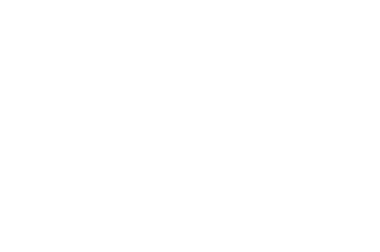

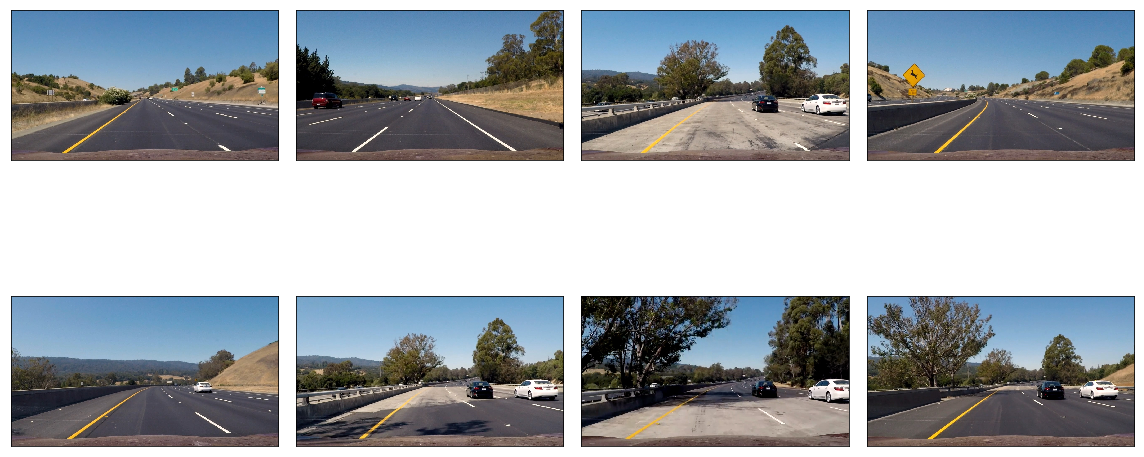

In [4]:
# load test images
import glob
image_files = glob.glob('./test_images/*.jpg')
imgs_camera = []
for img_file in image_files:
    imgs_camera.append(cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB))
plot_images_grid(imgs_camera)

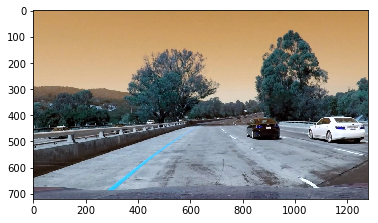

In [5]:
img_camera = cv2.imread('./test_images/test1.jpg')
plot_image(img_camera)

In [6]:
from camera_img_undistorter import CameraImageUndistorter
img_undistorter = CameraImageUndistorter()

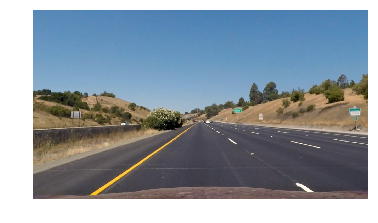

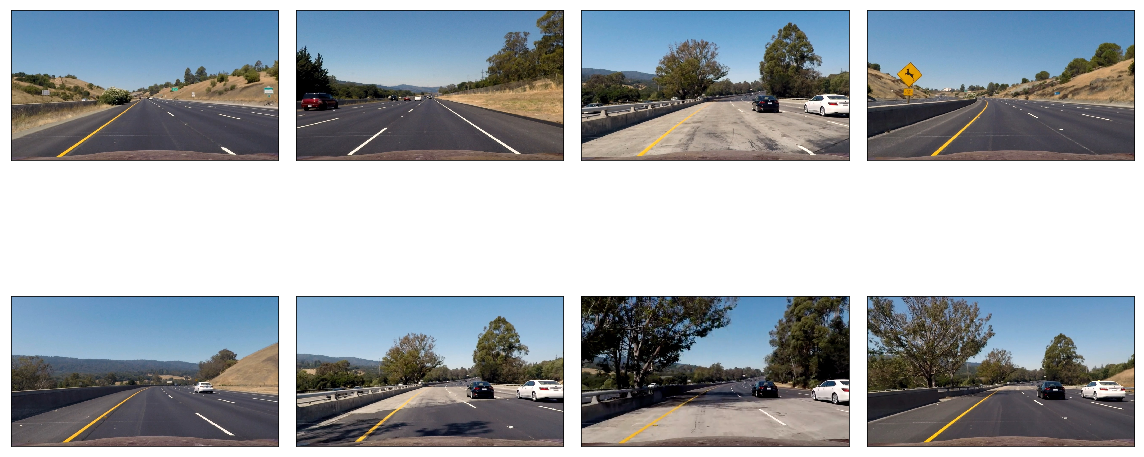

In [7]:
imgs_undistorted = [img_undistorter.undistort(img) for img in imgs_camera] 
plot_image(imgs_undistorted[0])
plot_images_grid(imgs_undistorted)

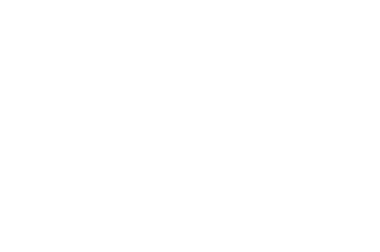

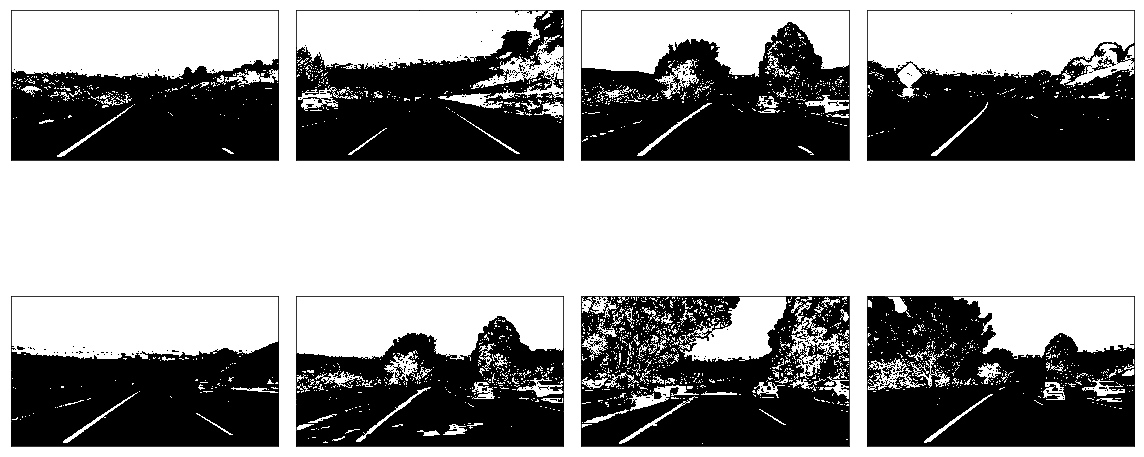

In [8]:
def color_threshold(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    thresh = (90, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

imgs_color  = [color_threshold(img) for img in imgs_undistorted] 
plot_images_grid(imgs_color, cmap='gray')

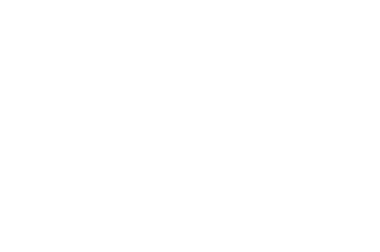

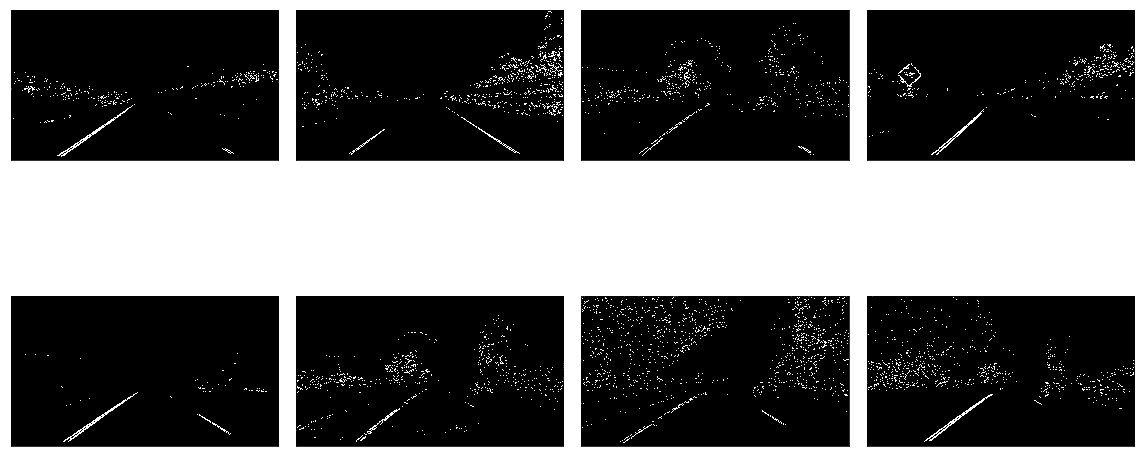

In [9]:
import lane_isolator
importlib.reload(lane_isolator)
from lane_isolator import LaneIsolator
lane_isolator = LaneIsolator(
    ksize=15,
    gradx_thresh=(30, 255),
    grady_thresh=(0, 255),
    mag_thresh=(10, 255),
    dir_thresh = (0.7, 1.3))
imgs_lanes  = [lane_isolator.isolate_lanes(img) for img in imgs_undistorted] 
plot_images_grid(imgs_lanes, cmap='gray')

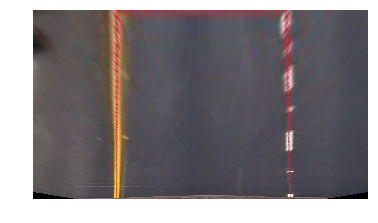

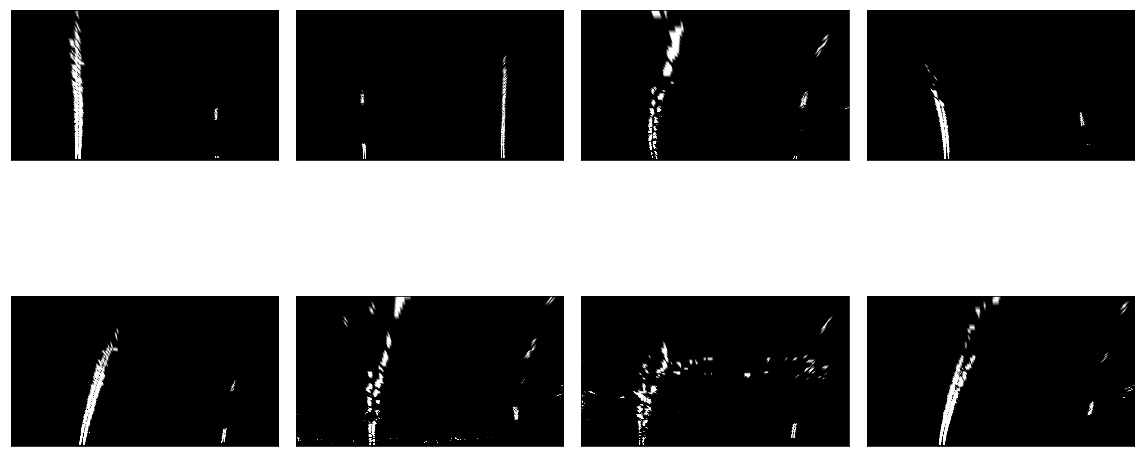

In [10]:
import camera_birdview_transform
importlib.reload(camera_birdview_transform)
from camera_birdview_transform import CameraImagePerspectiveTransform
img_transformer = CameraImagePerspectiveTransform()
imgs_lanes_birdview = [img_transformer.to_birdview(img) for img in imgs_lanes] 
plot_image(img_transformer.to_birdview(cv2.cvtColor(cv2.imread('./examples/straight_lines1_source_points.jpg'), cv2.COLOR_BGR2RGB)))
plot_images_grid(imgs_lanes_birdview, cmap='gray')

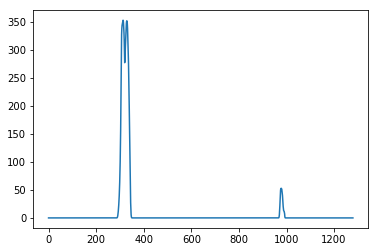

In [11]:
histograms = [np.sum(img[img.shape[0]//2:,:], axis=0) for img in imgs_lanes_birdview]
plt.plot(histograms[0])

In [23]:
import lane
importlib.reload(lane)
from lane import FittedLane
        
fitted_lanes = [FittedLane.fit(img_birdview) for img_birdview in imgs_lanes_birdview]

In [13]:
def plot_lane_lines(lane):
    out_img = lane.out_img
    
    # Generate x and y values for plotting
    img_height = out_img.shape[0]
    ploty = np.linspace(0, img_height-1, img_height )
    left_fitx = lane.line_left.x_pixels(ploty)
    right_fitx = lane.line_right.x_pixels(ploty)

    print("deviation from lane center: " + str(lane.deviation_from_lane_center_meters()))
    print("lane radius meters: " + str(lane.lane_radius_meters()))
    print("lane width meters: " + str(lane.lane_width_meters()))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

deviation from lane center: 0.074396673126
lane radius meters: 1905.44587697
lane width meters: 3.83126199451


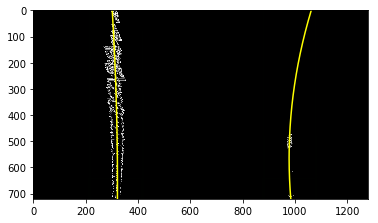

In [14]:
plot_lane_lines(fitted_lanes[0])

deviation from lane center: 0.0950585762816
lane radius meters: 20690.8868642
lane width meters: 3.79254702091


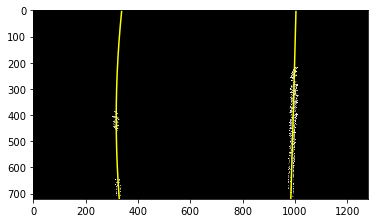

In [15]:
plot_lane_lines(fitted_lanes[1])

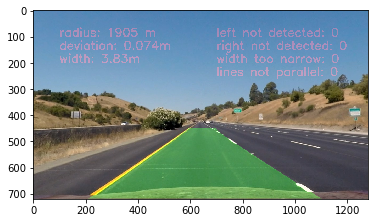

In [24]:
# TODO draw in original image

def augment_original_image(undist, lane):
    # Create an image to draw the lines on
    warp_zero = np.zeros((undist.shape[0], undist.shape[1])).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate points for plotting
    img_width = color_warp.shape[0]
    ploty = np.linspace(0, img_width-1, img_width )
    left_fitx = lane.line_left.x_pixels(ploty)
    right_fitx = lane.line_right.x_pixels(ploty)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = img_transformer.birdview_to_camera(color_warp)
    
    # write text for radius and deviation
    radius_str = "radius: {0:.0f} m".format(lane.lane_radius_meters())
    deviation_str = "deviation: {0:.3f}m".format(lane.deviation_from_lane_center_meters())
    lane_width_str = "width: {0:.2f}m".format(lane.lane_width_meters())
    lane_width_str = "width: {0:.2f}m".format(lane.lane_width_meters())
    left_not_detected_str = "left not detected: {0}".format(lane.left_not_detected_count)
    right_not_detected_str = "right not detected: {0}".format(lane.right_not_detected_count)
    width_too_narrow_str = "width too narrow: {0}".format(lane.lane_width_too_narrow_count)
    lines_not_parallel_str = "lines not parallel: {0}".format(lane.lane_lines_not_parallel_count)
    
    cv2.putText(newwarp, radius_str, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=255, thickness=4)
    cv2.putText(newwarp, deviation_str, (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=255, thickness=4)
    cv2.putText(newwarp, lane_width_str, (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=255, thickness=4)
    cv2.putText(newwarp, left_not_detected_str, (700,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=255, thickness=4)
    cv2.putText(newwarp, right_not_detected_str, (700,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=255, thickness=4)
    cv2.putText(newwarp, width_too_narrow_str, (700,200), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=255, thickness=4)
    cv2.putText(newwarp, lines_not_parallel_str, (700,250), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color=255, thickness=4)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def plot_in_original(undist, lane):
    img_augmented = augment_original_image(undist, lane)
    plt.imshow(img_augmented)
    
plot_in_original(imgs_undistorted[0], fitted_lanes[0])

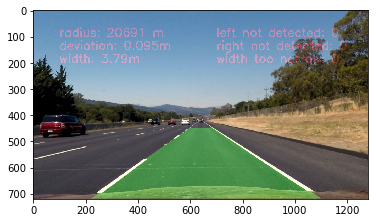

In [17]:
plot_in_original(imgs_undistorted[1], fitted_lanes[1])

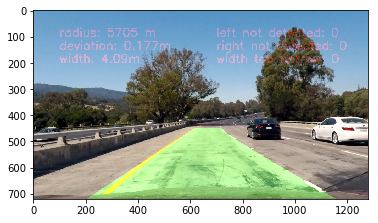

In [18]:
plot_in_original(imgs_undistorted[2], fitted_lanes[2])

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip = VideoFileClip("project_video.mp4")

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [26]:
import lane_smoother
importlib.reload(lane_smoother)
from lane_smoother import LaneSmoother

importlib.reload(lane)
from lane import FittedLane

lane_smooth = LaneSmoother()

def process_image(img):
    img_undistorted = img_undistorter.undistort(img)
    img_binary = lane_isolator.isolate_lanes(img_undistorted)
    img_binary_birdview = img_transformer.to_birdview(img_binary)
    lane = lane_smooth.fit(img_binary_birdview)
    # TODO smooth over time & filter
    return augment_original_image(img_undistorted, lane)

    # TODO cut out so we have a small video clip
clip_cut = clip.set_start(0).set_end(49)
clip_augmented = clip_cut.fl_image(process_image)
clip_augmented.write_videofile("project_video_augmented.mp4", audio=False, progress_bar=False)

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format("project_video_augmented.mp4"))

[MoviePy] >>>> Building video project_video_augmented.mp4
[MoviePy] Writing video project_video_augmented.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_augmented.mp4 

